In [1]:
"""A Pulse simulation backend based on Qiskit-Dynamics"""
import copy
import datetime
from typing import Dict, List, Optional, Tuple, Union
from itertools import chain
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 16

from qiskit import QuantumCircuit, IBMQ, schedule
from qiskit.circuit import CircuitInstruction
from qiskit.circuit.measure import Measure
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.models import PulseDefaults
from qiskit.providers.models.pulsedefaults import Command
from qiskit.providers.options import Options
import qiskit.pulse as pulse
from qiskit.pulse import Schedule, ScheduleBlock
from qiskit.pulse.transforms import block_to_schedule
from qiskit.qobj.pulse_qobj import PulseQobjInstruction, PulseLibraryItem
from qiskit.qobj.utils import MeasLevel, MeasReturnType
from qiskit.quantum_info import Statevector, DensityMatrix

from qiskit.result import Result
from qiskit.transpiler import InstructionProperties, Target

from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals

from qiskit_experiments.exceptions import QiskitError
from qiskit_experiments.test.utils import FakeJob

In [2]:
class IQPulseBackend(BackendV2):
    """Pulse Simulator abstract class"""

    def __init__(
        self,
        static_hamiltonian: np.ndarray,
        hamiltonian_operators: np.ndarray,
        dt: Optional[float] = 0.1 * 1e-9,
        **kwargs,
    ):
        """Hamiltonian and operators is the Qiskit Dynamics object"""
        super().__init__(
            None,
            name="PulseBackendV2",
            description="A PulseBackend simulator",
            online_date=datetime.datetime.utcnow(),
            backend_version="0.0.1",
        )
        self._defaults = PulseDefaults.from_dict(
            {
                "qubit_freq_est": [0],
                "meas_freq_est": [0],
                "buffer": 0,
                "pulse_library": [],
                "cmd_def": [],
            }
        )
        self.converter = None
        self.logical_levels = None
        self.noise = 'static_dissipators' in kwargs
        
        self.static_hamiltonian = static_hamiltonian
        self.hamiltonian_operators = hamiltonian_operators
        self.solver = Solver(self.static_hamiltonian, self.hamiltonian_operators, **kwargs)
        self._target = Target(dt=dt, granularity=16)
        
        self.model_dim = self.solver.model.dim
        if self.noise:
            self.model_dim = self.model_dim**2
        self.gound_state = np.zeros(self.model_dim)
        self.gound_state[0] = 1
        self.y_0 = np.eye(self.model_dim)
        self._simulated_pulse_unitaries = {}

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    def defaults(self):
        """return backend defaults"""
        return self._defaults

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    @property
    def default_pulse_unitaries(self) -> Dict[Tuple, np.array]:
        """Return the default unitary matrices of the backend."""
        return self._simulated_pulse_unitaries

    @default_pulse_unitaries.setter
    def default_pulse_unitaries(self, unitaries: Dict[Tuple, np.array]):
        """Set the default unitary pulses this allows the tests to simulate the pulses only once."""
        self._simulated_pulse_unitaries = unitaries

    @staticmethod
    def _get_info(instruction: CircuitInstruction) -> Tuple[Tuple[int], Tuple[float], str]:
        p_dict = instruction.operation
        qubit = tuple(int(str(val)[-2]) for val in instruction.qubits)
        params = tuple(float(val) for val in p_dict.params)
        return qubit, params, p_dict.name

#     @staticmethod
    def iq_data(
        self,
        probability: np.ndarray,
        shots: int,
        centers: List[Tuple[float, float]],
        width: float,
        phase: float = 0,
    ) -> Tuple[List, List]:
        """Generates IQ data for each logical levels

        Parameters
        ----------
        probability : np.ndarray
            probability of occupation
        shots : int
            Number of shots
        centers : List[Tuple[float, float]]
            The central i and q points for each level
        width : float
            Width of IQ data distribution
        phase : float, optional
            Phase of IQ data, by default 0

        Returns
        -------
        Tuple[List,List]
            (I,Q) data
        """
        
        counts_n = np.random.multinomial(shots, np.round(probability,5), size=1).T
        
        full_i = []
        full_q = []
        
        for idx, count_i in enumerate(counts_n):
            full_i.append(np.random.normal(loc=centers[idx][0], scale=width, size=count_i))
            full_q.append(np.random.normal(loc=centers[idx][1], scale=width, size=count_i))

        full_i = list(chain.from_iterable(full_i))
        full_q = list(chain.from_iterable(full_q))

        if not np.allclose(phase, 0.0):
            complex_iq = (full_i + 1.0j * full_q) * np.exp(1.0j * phase)
            full_i, full_q = complex_iq.real, complex_iq.imag

        return np.array([full_i, full_q]).reshape(shots,1,2).tolist()

    def _state_to_measurement_data(
        self,
        state: np.ndarray,
        shots: int,
        meas_level: MeasLevel,
        meas_return: MeasReturnType,
    ) -> Union[Dict[str, int], complex]:
        """Convert the state vector to IQ data or counts."""
        N = self.logical_levels
        self.curstate = state
        if self.noise == True:
            state = state.reshape(N,N)
            state = DensityMatrix(state / np.trace(state))
        else:
            state = Statevector(state / np.linalg.norm(state))
            
            
        if meas_level == MeasLevel.CLASSIFIED:
            measurement_data = state.sample_counts(shots)

        elif meas_level == MeasLevel.KERNELED:
            
            measurement_data = self.iq_data(
                state.probabilities(), shots, [(np.cos(idx*2*np.pi/N), np.sin(idx*2*np.pi/N)) for idx in range(N)], 0.2
            )
            if meas_return == "avg":
                measurement_data = np.average(np.array(measurement_data), axis=0)

        return measurement_data

    def solve(self, schedule: Union[ScheduleBlock, Schedule], qubits: Tuple[int]) -> np.ndarray:
        """Solves a single schdule block and returns the unitary"""
        if len(qubits) > 1:
            QiskitError("TODO multi qubit gates")
        if isinstance(schedule, ScheduleBlock):
            schedule = block_to_schedule(schedule)

        signal = self.converter.get_signals(schedule)
        time_f = schedule.duration * self.dt
        unitary = self.solver.solve(
            t_span=[0.0, time_f],
            y0=self.y_0,
            t_eval=[time_f],
            signals=signal,
            method="RK23",
        ).y[0]

        return unitary

    def run(self, run_input: Union[QuantumCircuit, List[QuantumCircuit]], **run_options) -> FakeJob:
        """run method takes circuits as input and returns FakeJob with shots/IQ data"""

        self.options.update_options(**run_options)
        shots = self.options.get("shots")
        meas_level = self.options.get("meas_level")
        meas_return = self.options.get("meas_level")

        result = {
            "backend_name": f"{self.__class__.__name__}",
            "backend_version": self.backend_version,
            "qobj_id": 0,
            "job_id": 0,
            "success": True,
            "results": [],
        }

        if isinstance(run_input, QuantumCircuit):
            run_input = [run_input]

        experiment_unitaries = copy.deepcopy(self.default_pulse_unitaries)

        for circuit in run_input:
            for name, schedule in circuit.calibrations.items():
                for (qubits, params), schedule_block in schedule.items():
                    if (name, qubits, params) not in experiment_unitaries:
                        experiment_unitaries[(name, qubits, params)] = self.solve(
                            schedule_block, qubits
                        )

            state_t = self.gound_state.copy()
            for instruction in circuit.data:
                qubits, params, inst_name = self._get_info(instruction)
                if inst_name in ["barrier", "measure"]:
                    continue
                unitary = experiment_unitaries[(inst_name, qubits, params)]
                state_t = unitary @ state_t

            return_data = self._state_to_measurement_data(
                state_t, shots, meas_level, meas_return
            )

            run_result = {
                "shots": shots,
                "success": True,
                "header": {"metadata": circuit.metadata},
                "meas_level": meas_level,
                "meas_level": meas_return,
                "data": {},
            }

            if meas_level == MeasLevel.CLASSIFIED:
                run_result["data"]["counts"] = return_data
            if meas_level == MeasLevel.KERNELED:
                run_result["data"]["memory"] = return_data

            result["results"].append(run_result)
        return FakeJob(self, Result.from_dict(result))

In [3]:
class SingleTransmonTestBackend(IQPulseBackend):
    """Three level anharmonic transmon qubit"""

    def __init__(
        self,
        qubit_frequency: float = 5e9,
        anharmonicity: float = -0.25e9,
        lambda_1: float = 1e9,
        lambda_2: float = 0.8e9,
        gamma_1:float = 1e4,
    ):
        """Initialise backend with hamiltonian parameters

        Parameters
        ----------
        qubit_frequency : float
            Frequency of the qubit (0-1)
        anharmonicity : float
            Qubit anharmonicity $\\alpha$ = f12 - f01
        lambda_0 : float
            Strength of 0-1 transition
        lambda_1 : float
            Strength of 1-2 transition
        """
        qubit_frequency_02 = 2 * qubit_frequency + anharmonicity
        ket0 = np.array([[1, 0, 0]]).T
        ket1 = np.array([[0, 1, 0]]).T
        ket2 = np.array([[0, 0, 1]]).T

        sigma_m1 = ket0 @ ket1.T.conj()
        sigma_m2 = ket1 @ ket2.T.conj()

        sigma_p1 = sigma_m1.T.conj()
        sigma_p2 = sigma_m2.T.conj()

        p1 = ket1 @ ket1.T.conj()
        p2 = ket2 @ ket2.T.conj()
        
        drift = 2 * np.pi * (qubit_frequency * p1 + qubit_frequency_02 * p2)
        control = [
            2 * np.pi * (lambda_1 * (sigma_p1 + sigma_m1) + lambda_2 * (sigma_p2 + sigma_m2))
        ]
        r_frame = 2 * np.pi * qubit_frequency * (p1 + 2 * p2)
        
        t1_dissipator = np.sqrt(gamma_1) * sigma_m1
        
        evaluation_mode = "dense_vectorized"
#         evaluation_mode = "dense"


        super().__init__(
            static_hamiltonian=drift,
            hamiltonian_operators=control,
            static_dissipators=[t1_dissipator],
            rotating_frame=r_frame,
            rwa_cutoff_freq=1.9 * qubit_frequency,
            rwa_carrier_freqs=[qubit_frequency],
            evaluation_mode = evaluation_mode,
        )
    
        self.logical_levels = 3

        self._defaults = PulseDefaults.from_dict(
            {
                "qubit_freq_est": [qubit_frequency / 1e9],
                "meas_freq_est": [0],
                "buffer": 0,
                "pulse_library": [],
                "cmd_def": [
                    Command.from_dict(
                        {
                            "name": "x",
                            "qubits": [0],
                            "sequence": [
                                PulseQobjInstruction(
                                    name="parametric_pulse",
                                    t0=0,
                                    ch="d0",
                                    label="Xp_d0",
                                    pulse_shape="drag",
                                    parameters={
                                        "amp": (0.1 + 0j),
                                        "beta": 5,
                                        "duration": 160,
                                        "sigma": 16,
                                    },
                                ).to_dict()
                            ],
                        }
                    ).to_dict(),
                    Command.from_dict(
                        {
                            "name": "sx",
                            "qubits": [0],
                            "sequence": [
                                PulseQobjInstruction(
                                    name="parametric_pulse",
                                    t0=0,
                                    ch="d0",
                                    label="X90p_d0",
                                    pulse_shape="drag",
                                    parameters={
                                        "amp": (0.1 + 0j) / 2,
                                        "beta": 5,
                                        "duration": 160,
                                        "sigma": 16,
                                    },
                                ).to_dict()
                            ],
                        }
                    ).to_dict(),
                ],
            }
        )
        self._target = Target(
            qubit_properties=[QubitProperties(frequency=qubit_frequency)],
            dt=self.dt,
            granularity=16,
        )
        measure_props = {
            (0,): InstructionProperties(duration=0, error=0),
        }
        self._target.add_instruction(Measure(), measure_props)
        self.converter = InstructionToSignals(self.dt, carriers={"d0": qubit_frequency})

        # TODO RZ gate
        default_schedules = [
            self._defaults.instruction_schedule_map.get("x", (0,)),
            self._defaults.instruction_schedule_map.get("sx", (0,)),
        ]
        self._simulated_pulse_unitaries = {
            (schedule.name, (0,), ()): self.solve(schedule, (0,)) for schedule in default_schedules
        }

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
h_backend = provider.get_backend("ibmq_lima")

In [8]:
props = h_backend.properties()
print(h_backend.configuration().dt)
[(item.name,item.value,item.unit) for item in props.qubits[0]]


2.2222222222222221e-10


[('T1', 97.50998508141137, 'us'),
 ('T2', 178.30038934156997, 'us'),
 ('frequency', 5.029747318814328, 'GHz'),
 ('anharmonicity', -0.33574155258829724, 'GHz'),
 ('readout_error', 0.02310000000000001, ''),
 ('prob_meas0_prep1', 0.03920000000000001, ''),
 ('prob_meas1_prep0', 0.007, ''),
 ('readout_length', 5351.11111111111, 'ns')]

In [47]:
pulse_backend = SingleTransmonTestBackend(
#                                           qubit_frequency=5.0*1e9,
#                                           anharmonicity=-0.4*1e9,
#                                           lambda_1=1e9,
#                                           lambda_2=0.5e9,
#                                           gamma_1=1e4
                                         )

In [48]:
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import (
    FixedFrequencyTransmon,
)
qubit = 0
library = FixedFrequencyTransmon(default_values={"duration": 320})
cals = Calibrations.from_backend(pulse_backend, libraries=[library])

In [49]:
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal

freq01_estimate = pulse_backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate - 15e6, freq01_estimate + 15e6, 51)
spec = RoughFrequencyCal(qubit, cals, frequencies, backend=pulse_backend)
spec.set_experiment_options(amp=0.005)

In [50]:
spec_data = spec.run().block_for_results()

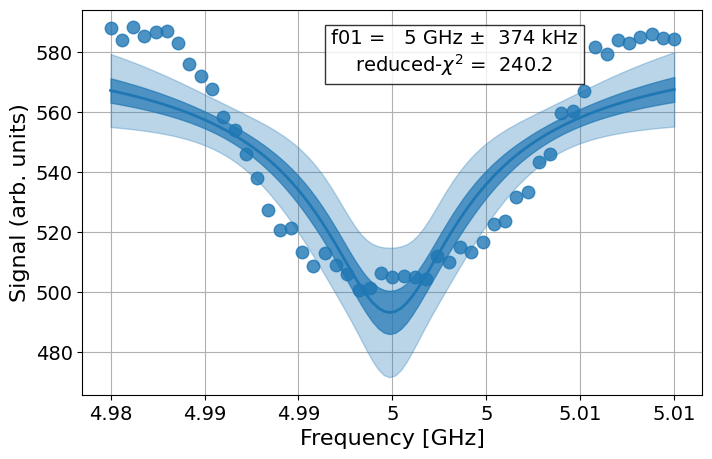

In [46]:
spec_data.figure(0)

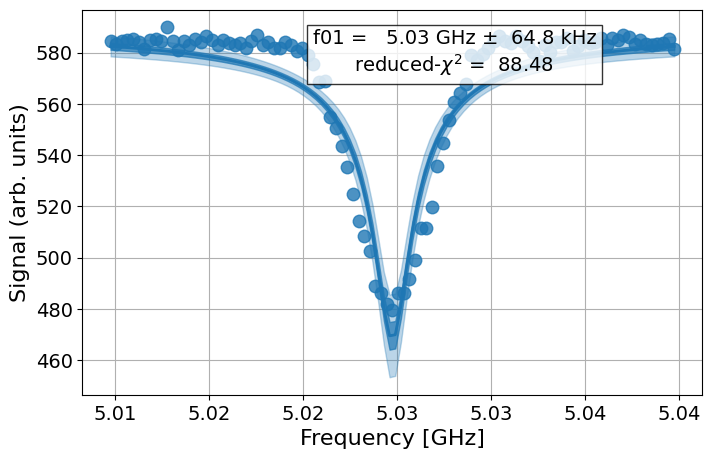

In [16]:
spec_data.figure(0)

In [10]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

rabi = RoughXSXAmplitudeCal(
    qubit, cals, backend=pulse_backend, amplitudes=np.linspace(-0.1, 0.1, 101)
)

In [11]:
rabi_data = rabi.run().block_for_results()

/home/rupeshknn/mambaforge/envs/exp/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


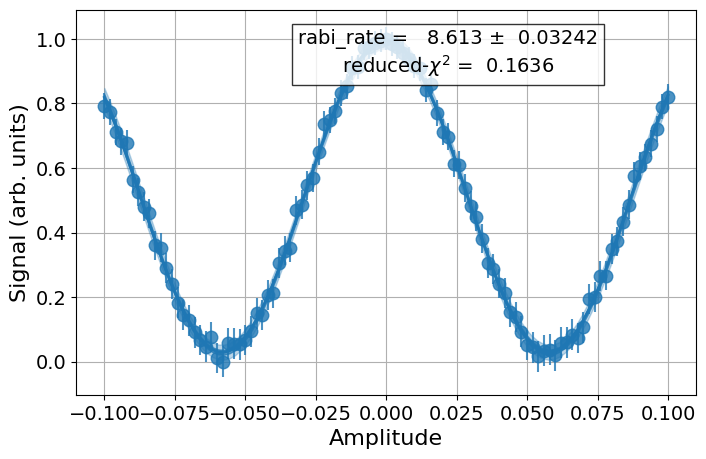

In [12]:
rabi_data.figure(0)

In [170]:
# hamiltonian_solver.model.evaluate(0)

In [177]:
y0 = np.eye(9)#DensityMatrix(ket0 @ ket0.T) #Statevector([1.0, 0.0, 0.0])
dt = 0.1*1e-9
sigma = 40
amp =  0.05833786
duration = 160
T = duration * dt

In [179]:
converter = InstructionToSignals(dt, carriers={"d0": qubit_frequency})
def make_signal(duration, amp, sigma, w, dt=dt):

    with pulse.build(name="spec") as spec:
        shift = w - qubit_frequency
        pulse.shift_frequency(shift, pulse.DriveChannel(0))
        pulse.play(
            pulse.Gaussian(duration=duration, amp=amp, sigma=sigma),
            pulse.DriveChannel(0),
        )
        pulse.shift_frequency(-shift, pulse.DriveChannel(0))

    signals = converter.get_signals(spec)
    return signals, spec.draw()

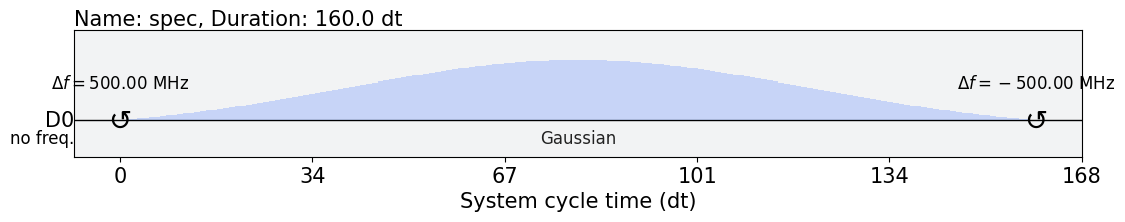

In [180]:
make_signal(duration, amp, sigma, qubit_frequency*1.1, dt=dt)[1]

In [181]:
result = hamiltonian_solver.solve(
    t_span=[0.0, T*2],
    y0=y0,
#     t_eval=[T],
    signals=make_signal(duration, amp, sigma, qubit_frequency, dt=dt)[0],
    method="RK23",
).y

In [191]:
rho_g = ket0 @ ket0.T
gs_vec = rho_g.T.reshape(9, 1)

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [214]:
result_vec = [DensityMatrix((res @ gs_vec).reshape(3,3)) for res in result]

In [215]:
probs = np.array([den.probabilities() for den in result_vec])

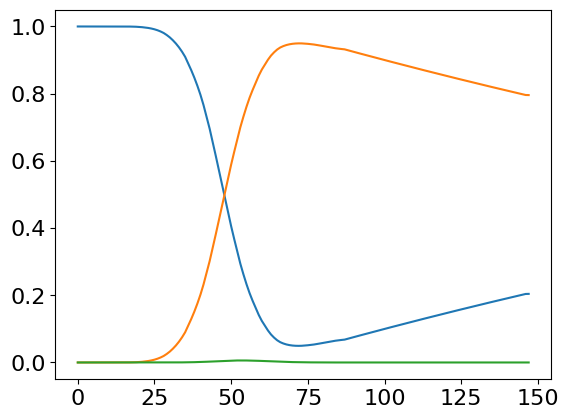

In [216]:
plt.plot(probs)

7.0